# Question-2 : Image compression using clustering 

I divided the programing part into following steps:
    - Random selection of the centers
    - Computing the norm-2 squared distance for rach points from the centeroids 
    - Assigning each points to neasrest centeroids 
    - Update the centorids with in the clusters
    - Calculating the objective function
    - Chekcing whether the convergence is occured 
    - Combining the above steps to establish the k-means algorithm
    - Adjusting the K-means combined code, so it can easily digest the pictures and produce compressed images
    - Running the algorithm on the pictures, with desired K values

## Coding:

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

To start the algorithm,  Let's randomly choose  k  observations from the data:

In [7]:
def init_centers(X, k):
    """
    Randomly samples k observations from X as centers.
    Returns these centers as a (k x d) numpy array.
    """
    
    from numpy.random import choice
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]
    

Computing the distances
Implement a function that computes a distance matrix,  S=(sij)  
It should return a Numpy matrix S[:m, :k].

In [8]:
#####this part of the code was later modified later as it was taking huge time
def compute_d(X, centers):
    m = len(X)
    k = len(centers)
    S = np.empty((m, k))
    for i in range(m):
        for j in range(k):
            d_ij = dist_squared = np.sum(np.square(X[i] - centers[j]))
            S[i, j] = d_ij
    return S

In [9]:
#####this part of the code was later modified later as it was taking huge time
def compute_d3(X, centers):
    m = len(X)
    k = len(centers)
    S = np.empty((m, k))
    for i in range(m):
        for j in range(k):
            d_i = np.linalg.norm(X[i, :] - centers, ord=2, axis=1)
            S[i, :] = d_i**2
    return S


this is the time optimized code for distance calculation, thanks to this web address:
https://medium.com/swlh/euclidean-distance-matrix-4c3e1378d87f

In [10]:
#####this is the time optimized code for distance calculation, thanks to this web address:
#https://medium.com/swlh/euclidean-distance-matrix-4c3e1378d87f
def compute_d2(X, centers):
    #S= np.dot(X.T, X) - 2* np.dot(X.T, centers) + np.dot(centers.T, centers)
    #S= np.dot(X, X.T) - 2* np.dot(centers,X.T) + np.dot(centers,centers.T)
    p1 = np.sum(X**2,axis=1)[:,np.newaxis]
    p2 = np.sum(centers**2, axis=1)
    p3 = -2 * np.dot(X,centers.T)
    S = p1+p2+p3
    return S

Now that we have our centeroids and also calculated the distances from our sample points to each cluster, we can assigan each point to it's corresponding cluster, based on the minimum calculated distance 

In [11]:
def assign_cluster_labels(S):
    
    return np.argmin(S, axis=1)

the centeroids need to be updated as per the updated labels

In [12]:
def update_centers(X, y):

    m, d = X.shape
    k = max(y) + 1
    assert m == len(y)
    assert (min(y) >= 0)
    
    centers = np.empty((k, d))
    for j in range(k):
        # Compute the new center of cluster j,
        
        centers[j, :d] = np.mean(X[y == j, :], axis=0)
        
    return centers

Given the squared distances, return the within-cluster sum of squares:

In [13]:
def WCSS(S):
    
    return np.sum(np.amin(S, axis=1))
    

Lastly, here is a function to check whether the centers have moved, given two instances of the center values. It accounts for the fact that the order of centers may have changed.

In [14]:
def has_converged(old_centers, centers):
    return set([tuple(x) for x in old_centers]) == set([tuple(x) for x in centers])

Put all of the preceding building blocks together to implement   k -means algorithm:

In [68]:
def kmeans(X, k,max_steps=np.inf):
    import math
    
    centers = init_centers(X, k)
    
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_centers = centers
        
        S = compute_d2(X, centers)
        labels = assign_cluster_labels(S)
        centers = update_centers(X, labels)
        converged = has_converged(old_centers, centers)
        
        if math.isnan(WCSS (S)):
            print ("####empty cluster, you need to lower the number of clusters,k")
            return labels + 0.5
        else:
    
            i += 1
    print("#####")
    print ("number of required iterations to converge=", i)
    return labels


Read image and store it as a 3 dimensional image array

In [43]:
from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline

def read_img(path):
    """
    Read image and store it as an array, given the image path. 
    Returns the 3 dimensional image array.
    """
    img = Image.open(path)
    img_arr = np.array(img, dtype='int32')
    img.close()
    return img_arr

def display_image(arr):
    """
    display the image
    input : 3 dimensional array
    """
    arr = arr.astype(dtype='uint8')
    img = Image.fromarray(arr, 'RGB')
    imshow(np.asarray(img))
    

the cluster_image function does the followings:
1. reshape the 3D matrix, image, to a 2D one
2. apply the k-means algorithm to the 2D matrix and identify for eaxh pixel which cluster it belongs to
3. generate the dictionary that assigns each centeroids to  it's poistion, or correpsoing colors
4. output the 2D matrix, that each pixel is assigned to the nearest centeroid

In [44]:
def cluster_image(image,centers_Number):
    r, c, l = image.shape
    img_reshaped = np.reshape(image, (r*c, l), order="C")
    
    labels = kmeans(img_reshaped, centers_Number)
    ind = np.column_stack((img_reshaped, labels))
    centers_dic = {}
    for i in set(labels):
        c = ind[ind[:,3] == i].mean(axis=0)
        centers_dic[i] = c[:3]
    img_clustered = np.array([centers_dic[i] for i in labels])
    
    return img_clustered
    

convert the above clustered image to a 3D Matrix, similar to the original image, for furthure visulaization 

In [45]:
def compress_image (cluster_image, image):
    r, c, l = image.shape
    return np.reshape(cluster_image, (r, c, l), order="C") 


the following function combines the above written functions into one and monitor the timing of the process. Also if any cluster is empty, with no points associate, it warns the user to narrow down the k, cluster numbers. 

In [46]:
def KMeans_on_image (input_image, centers_Number):
    import time
    from datetime import timedelta
    img_arr = read_img(input_image)
    start = time.time()
    img_clusterd = cluster_image (img_arr,centers_Number)
    end = time.time()
    Delta = end - start
    Elapsed=str(timedelta(seconds=Delta))
    print("Time taken for applying k-means algorithm on {} with K={} is: \n {}".format(input_image,centers_Number, Elapsed))
    
    img_compressed = compress_image (img_clusterd, img_arr)
    return img_compressed


## Running the KMeans_on_image on the "Football" image , and compress the image with 
## k = 2,4,8,16. The timing and the number of runs for each k to converge is reported

In [47]:
####for k-means running on list of K=[2,4,8,16], 'football' iamge
Compressed_Image={}
for k in [2,4,8,16]:
    Compressed_Image[k]=KMeans_on_image ("football.bmp", k)

#####
number of required iterations to converge= 21
Time taken for applying k-means algorithm on football.bmp with K=2 is: 
 0:00:02.044429
#####
number of required iterations to converge= 43
Time taken for applying k-means algorithm on football.bmp with K=4 is: 
 0:00:04.995882
#####
number of required iterations to converge= 141
Time taken for applying k-means algorithm on football.bmp with K=8 is: 
 0:00:21.918935
#####
number of required iterations to converge= 101
Time taken for applying k-means algorithm on football.bmp with K=16 is: 
 0:00:20.550296


### Plotting the original & compressed Football images:

Text(0.5, 1.0, 'K=16')

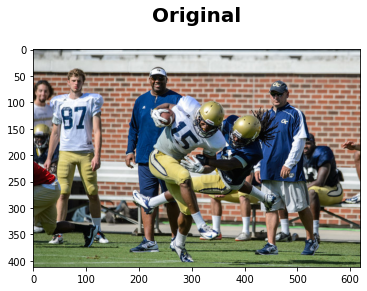

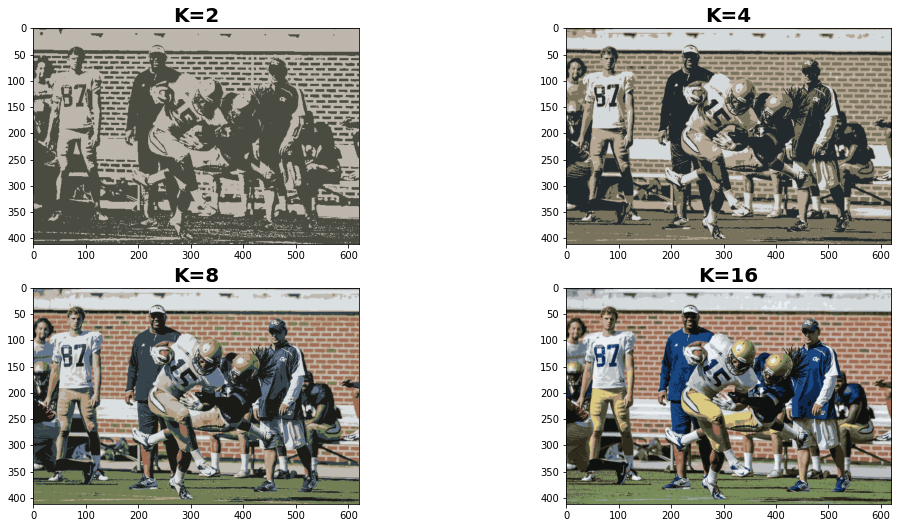

In [48]:
#plotting the original and compressed images, 'football'
import matplotlib.pyplot as plt


intro_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.imshow(plt.imread('football.bmp'))
ax.set_title('Original\n', fontsize=20, weight='bold')

f, axarr = plt.subplots(2,2,figsize=(17.5,8.75))
axarr[0,0].imshow(Compressed_Image[2]/255)
axarr[0,0].set_title('K=2', fontsize=20, weight='bold')
axarr[0,1].imshow(Compressed_Image[4]/255)
axarr[0,1].set_title('K=4', fontsize=20, weight='bold')
axarr[1,0].imshow(Compressed_Image[8]/255)
axarr[1,0].set_title('K=8', fontsize=20, weight='bold')
axarr[1,1].imshow(Compressed_Image[16]/255)
axarr[1,1].set_title('K=16', fontsize=20, weight='bold')

## Running the KMeans_on_image on the "Beach" image , and compress the image with 
## k = 2,4,8,16. The timing and the number of runs for each k to converge is reported.

In [49]:
####for k-means running on list of K=[2,4,8,16], 'beach' iamge
Compressed_Image_B={}
for k in [2,4,8,16]:
    Compressed_Image_B[k]=KMeans_on_image ("beach.bmp", k)

#####
number of required iterations to converge= 16
Time taken for applying k-means algorithm on beach.bmp with K=2 is: 
 0:00:00.436832
#####
number of required iterations to converge= 20
Time taken for applying k-means algorithm on beach.bmp with K=4 is: 
 0:00:00.644773
#####
number of required iterations to converge= 41
Time taken for applying k-means algorithm on beach.bmp with K=8 is: 
 0:00:01.656289
#####
number of required iterations to converge= 74
Time taken for applying k-means algorithm on beach.bmp with K=16 is: 
 0:00:04.068383


### Plotting the original & compressed Beach images:

Text(0.5, 1.0, 'K=16')

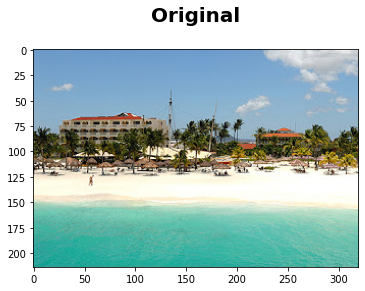

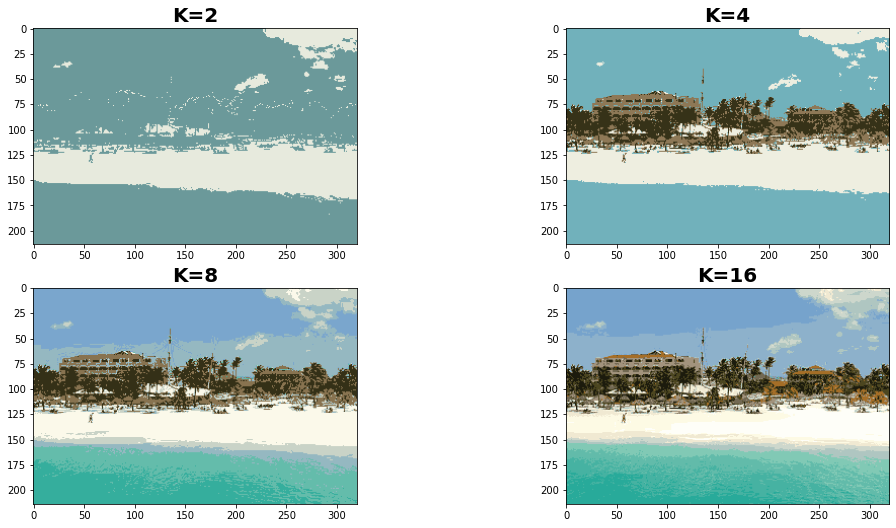

In [50]:
#plotting the original and compressed images, 'beach'
#import matplotlib.pyplot as plt


intro_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.imshow(plt.imread('beach.bmp'))
ax.set_title('Original\n', fontsize=20, weight='bold')

f, axarr = plt.subplots(2,2,figsize=(17.5,8.75))
axarr[0,0].imshow(Compressed_Image_B[2]/255)
axarr[0,0].set_title('K=2', fontsize=20, weight='bold')
axarr[0,1].imshow(Compressed_Image_B[4]/255)
axarr[0,1].set_title('K=4', fontsize=20, weight='bold')
axarr[1,0].imshow(Compressed_Image_B[8]/255)
axarr[1,0].set_title('K=8', fontsize=20, weight='bold')
axarr[1,1].imshow(Compressed_Image_B[16]/255)
axarr[1,1].set_title('K=16', fontsize=20, weight='bold')

## Running the KMeans_on_image on additional image-1, and compress the image with k = 2,4,8,16. The timing and the number of runs for each k to converge is reported

Due to nature of this image, alots white constant pixel, the k-means clustering faced empty clusters for number of k-values, mostly for the higher K values. The code however didnot halt and also reported the empty clusters accordingly. 

In [69]:
####for k-means running on list of K=[2,4,8,16], 'my_PIC.JPG' iamge
Compressed_Image_M={}
for k in [2,4,8,16]:
    Compressed_Image_M[k]=KMeans_on_image ("my_PIC.JPG", k)

#####
number of required iterations to converge= 9
Time taken for applying k-means algorithm on my_PIC.JPG with K=2 is: 
 0:00:00.149613
#####
number of required iterations to converge= 10
Time taken for applying k-means algorithm on my_PIC.JPG with K=4 is: 
 0:00:00.138629
####empty cluster, you need to lower the number of clusters,k
Time taken for applying k-means algorithm on my_PIC.JPG with K=8 is: 
 0:00:00.085771
####empty cluster, you need to lower the number of clusters,k
Time taken for applying k-means algorithm on my_PIC.JPG with K=16 is: 
 0:00:00.077792


## Plotting the original & compressed Additional image-1:

For the above run images associated with K=8 & k=16 had empty clusters, but depending on the initial centorids that varies for different K numbers. Somtimes even for K=2 I faced empty clusters, and even sometime I had an ok image for k=8. 

Text(0.5, 1.0, 'K=16')

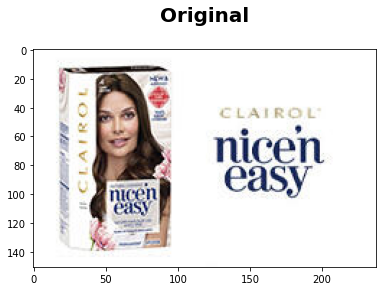

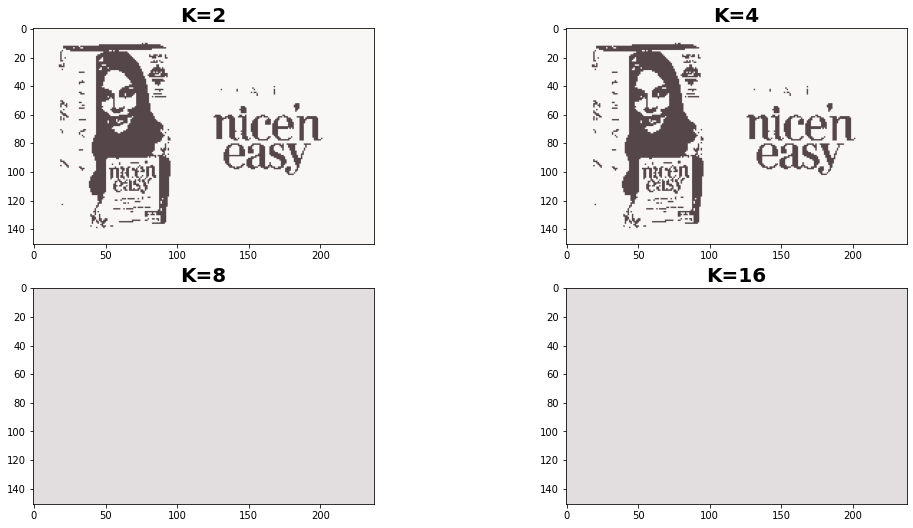

In [70]:
#plotting the original and compressed images, 'my_PIC.JPG'
#import matplotlib.pyplot as plt


intro_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.imshow(plt.imread('my_PIC.JPG'))
ax.set_title('Original\n', fontsize=20, weight='bold')

f, axarr = plt.subplots(2,2,figsize=(17.5,8.75))
axarr[0,0].imshow(Compressed_Image_M[2]/255)
axarr[0,0].set_title('K=2', fontsize=20, weight='bold')
axarr[0,1].imshow(Compressed_Image_M[4]/255)
axarr[0,1].set_title('K=4', fontsize=20, weight='bold')
axarr[1,0].imshow(Compressed_Image_M[8]/255)
axarr[1,0].set_title('K=8', fontsize=20, weight='bold')
axarr[1,1].imshow(Compressed_Image_M[16]/255)
axarr[1,1].set_title('K=16', fontsize=20, weight='bold')

## Running the KMeans_on_image on additional image-2 image , and compress the image with k = 2,4,8,16. The timing and the number of runs for each k to converge is reported

In [60]:
####for k-means running on list of K=[2,4,8,16], 'Food.JPG' iamge
Compressed_Image_F={}
for k in [2,4,8,16]:
    Compressed_Image_F[k]=KMeans_on_image ("Food.JPG", k)

#####
number of required iterations to converge= 19
Time taken for applying k-means algorithm on Food.JPG with K=2 is: 
 0:00:00.527603
#####
number of required iterations to converge= 32
Time taken for applying k-means algorithm on Food.JPG with K=4 is: 
 0:00:00.808534
#####
number of required iterations to converge= 129
Time taken for applying k-means algorithm on Food.JPG with K=8 is: 
 0:00:03.851637
#####
number of required iterations to converge= 83
Time taken for applying k-means algorithm on Food.JPG with K=16 is: 
 0:00:03.247185


## Plotting the original & compressed Additional image-2:

Text(0.5, 1.0, 'K=16')

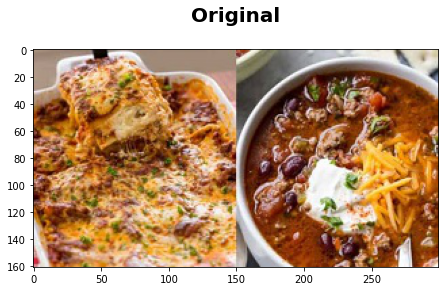

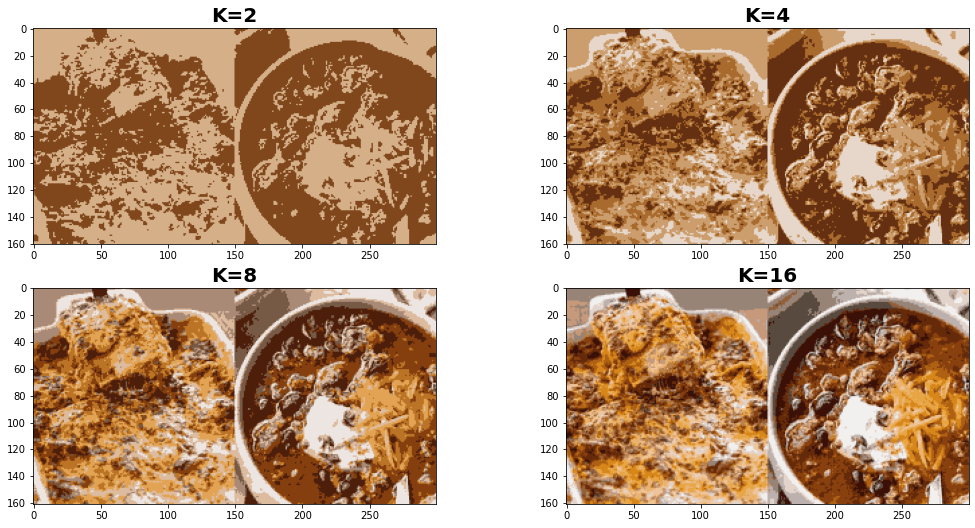

In [61]:
#plotting the original and compressed images, 'Food.JPG'
#import matplotlib.pyplot as plt


intro_fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.imshow(plt.imread('Food.JPG'))
ax.set_title('Original\n', fontsize=20, weight='bold')

f, axarr = plt.subplots(2,2,figsize=(17.5,8.75))
axarr[0,0].imshow(Compressed_Image_F[2]/255)
axarr[0,0].set_title('K=2', fontsize=20, weight='bold')
axarr[0,1].imshow(Compressed_Image_F[4]/255)
axarr[0,1].set_title('K=4', fontsize=20, weight='bold')
axarr[1,0].imshow(Compressed_Image_F[8]/255)
axarr[1,0].set_title('K=8', fontsize=20, weight='bold')
axarr[1,1].imshow(Compressed_Image_F[16]/255)
axarr[1,1].set_title('K=16', fontsize=20, weight='bold')

# Observations and Conclusions:

## How long does it need to converge for each K & how many iterations needed?

### Football Image:
1. K=2: It took 05.682759 sec  to converge  in  29  iterations
2. K=4: It took 07.233746 sec  to converge  in  31  iterations
3. K=8: It took 14.945057 sec  to converge  in  53  iterations
4. K=16: It took 32.544369 sec  to converge  in  96  iterations

### Beach Image:
1. K=2: It took 00.976035 sec  to converge  in  19  iterations
2. K=4: It took 01.677290 sec  to converge  in  26  iterations
3. K=8: It took 02.265060 sec  to converge  in  31  iterations
4. K=16: It took 06.787994 sec  to converge  in  68  iterations

### My- Image No.1 :
1. K=2: It took 00.251121 sec  to converge  in  9  iterations
2. K=4: It took 00.657739 sec  to converge  in  19  iterations
3. K=8: Not Converged due to empty cluster(s)
4. K=16: Not Converged due to empty cluster(s)

### My- Image No.2:
1. K=2: It took 00.737197 sec  to converge  in  21  iterations
2. K=4: It took 01.604903 sec  to converge  in  34  iterations
3. K=8: It took 05.347727 sec  to converge  in  97  iterations
4. K=16: It took 11.109212 sec  to converge  in  171  iterations

We should note the above numbers will certinly vary, since each run use random inital points for the cetroids assignemnts, and that affect some variation in between of each run results. is also dependent on the inital results as k-mean in non-convex and we get the local minimal not the global one. 

## Run your k-means implementation with different initialization centroids.  How does this affect your final result?

The k-mean algorithm is actually a non convex optimization, and different initialization centroids, out of all the possible potential assignemnts, determine cluster assignments and consequently cetroids for upcoming runs. In order to have examined all the posiibilites of the ultimate answers, we need to run the alogorithm for $k^m$, for $k$ cluster numbers and $m$ datapoints. That's the way to have examined all the Local minimum and finding our the true Global minimum. 
The following picture is from the course material:

![alt text](Local_Global_Minimum.png)

To better illustrate this I ran the algorithm on the football image, for 10 times and with 32 clusters and reported the compressed images and corresponding stats:

In [67]:
####for k-means running on list of K=[32],10 times, football.bmp
Compressed_Image_F_32={}
for i in range(10):
    Compressed_Image_F_32[i]=KMeans_on_image ("football.bmp", 32)

#####
number of required iterations to converge= 180
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:00:55.945458
#####
number of required iterations to converge= 218
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:01:09.210945
#####
number of required iterations to converge= 212
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:01:06.482083
#####
number of required iterations to converge= 140
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:00:43.371322
#####
number of required iterations to converge= 100
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:00:31.389667
#####
number of required iterations to converge= 151
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:00:47.726388
#####
number of required iterations to converge= 172
Time taken for applying k-means algorithm on football.bmp with K=32 is: 
 0:00:53.127777
#####


### Stats for the 10 runs on the Football Image, all with K=32, But different starting centroids:

1. Run-1: It took 38.915744 sec  to converge  in  115  iterations
2. Run-2: It took 01:00.294019 sec  to converge  in 175 iterations
3. Run-3: It took 34.013130 sec  to converge  in  99  iterations
4. Run-4: It took 57.997153 sec  to converge  in  168  iterations
5. Run-5: It took 29.567932 sec  to converge  in  86  iterations
6. Run-6: It took 30.931970 sec  to converge  in  90  iterations
7. Run-7: It took 01:06.508535 sec  to converge  in  192  iterations
8. Run-8: It took 35.506821 sec  to converge  in  104  iterations
9. Run-9: It took 02:22.664041 sec  to converge  in  412  iterations
10. Run-10: It took 02:16.485459 sec  to converge  in  408  iterations


As we can see there is wide range of differences between the runs. 


Text(0.5, 1.0, '10th Run (K=32)')

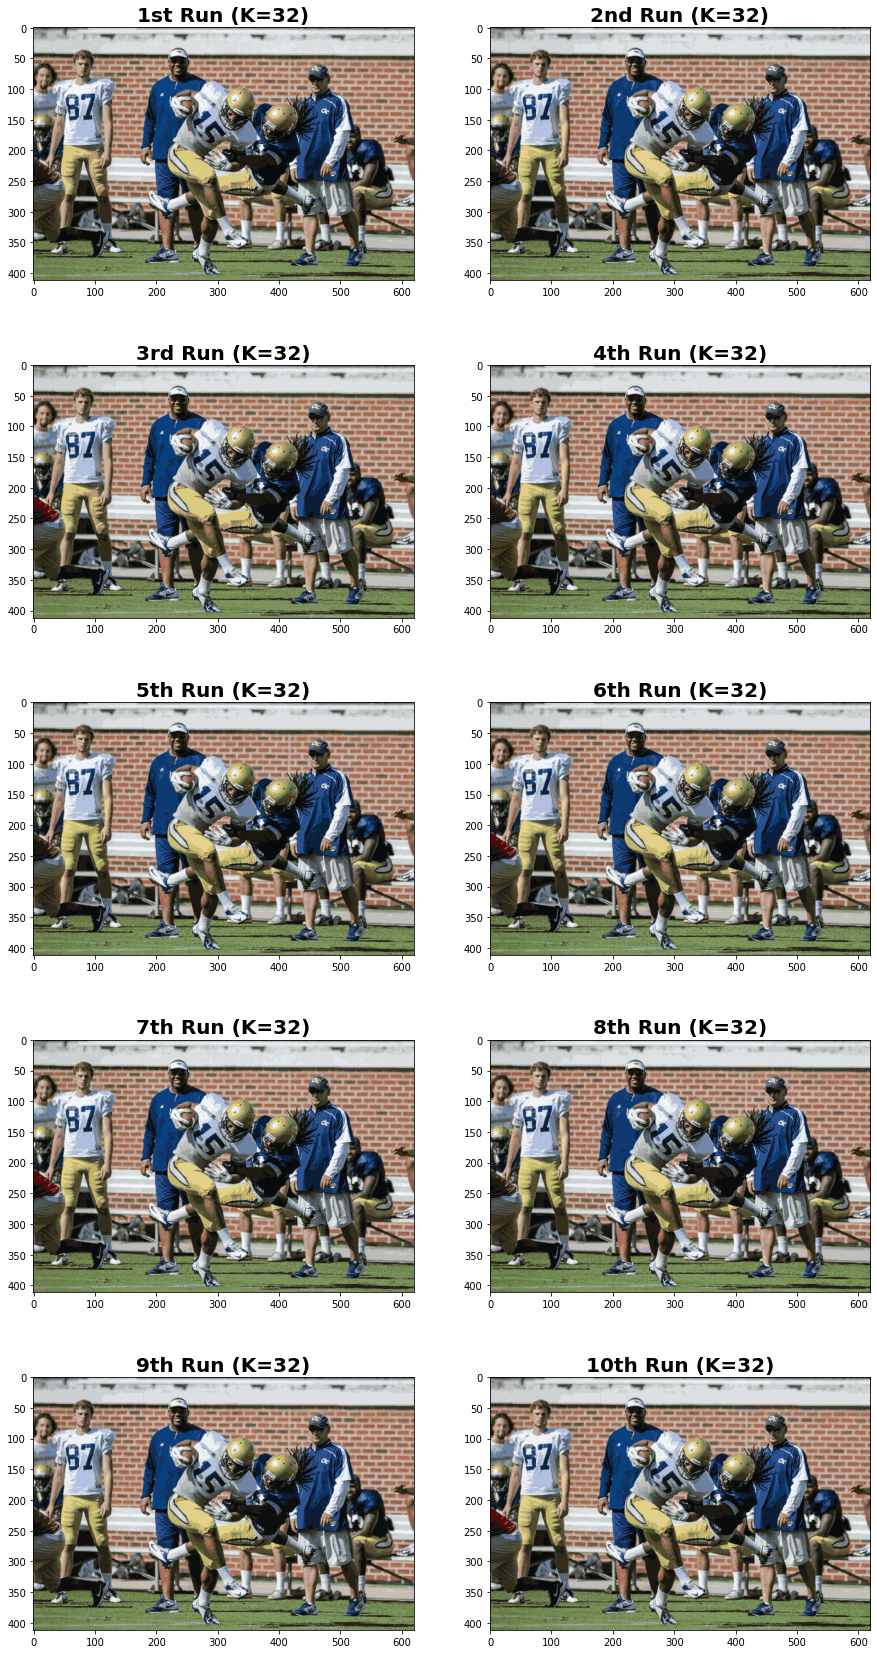

In [71]:
f, axarr = plt.subplots(5,2,figsize=(15,30))
axarr[0,0].imshow(Compressed_Image_F_32[0]/255)
axarr[0,0].set_title('1st Run (K=32)', fontsize=20, weight='bold')

axarr[0,1].imshow(Compressed_Image_F_32[1]/255)
axarr[0,1].set_title('2nd Run (K=32)', fontsize=20, weight='bold')

axarr[1,0].imshow(Compressed_Image_F_32[2]/255)
axarr[1,0].set_title('3rd Run (K=32)', fontsize=20, weight='bold')

axarr[1,1].imshow(Compressed_Image_F_32[3]/255)
axarr[1,1].set_title('4th Run (K=32)', fontsize=20, weight='bold')

axarr[2,0].imshow(Compressed_Image_F_32[4]/255)
axarr[2,0].set_title('5th Run (K=32)', fontsize=20, weight='bold')

axarr[2,1].imshow(Compressed_Image_F_32[5]/255)
axarr[2,1].set_title('6th Run (K=32)', fontsize=20, weight='bold')

axarr[3,0].imshow(Compressed_Image_F_32[6]/255)
axarr[3,0].set_title('7th Run (K=32)', fontsize=20, weight='bold')

axarr[3,1].imshow(Compressed_Image_F_32[7]/255)
axarr[3,1].set_title('8th Run (K=32)', fontsize=20, weight='bold')

axarr[4,0].imshow(Compressed_Image_F_32[8]/255)
axarr[4,0].set_title('9th Run (K=32)', fontsize=20, weight='bold')

axarr[4,1].imshow(Compressed_Image_F_32[9]/255)
axarr[4,1].set_title('10th Run (K=32)', fontsize=20, weight='bold')

### Differences within the compressed images with same cluster numbers:

Within the compressed images also, even though it may not be so easy to point out, but there are differences too. For an example, I have re-plotted the images from the 5th and 9th runs, below. Look at the hats for the palyers in these two images, surely there are visible difference:  

Text(0.5, 1.0, '5th Run (K=32)')

Text(0.5, 1.0, '9th Run (K=32)')

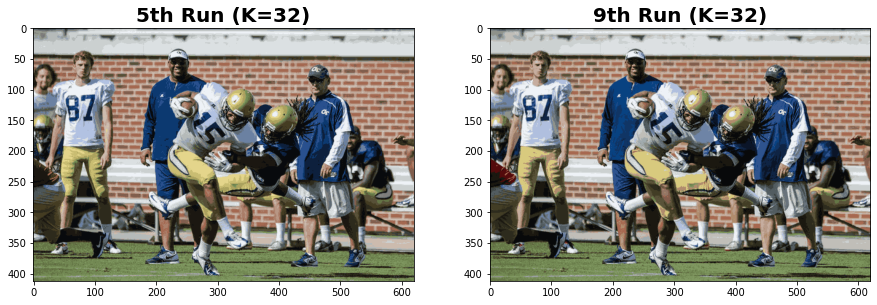

In [225]:
f, axarr = plt.subplots(1,2,figsize=(15,30))

axarr[0].imshow(Compressed_Image_F_32[4]/255)
axarr[0].set_title('5th Run (K=32)', fontsize=20, weight='bold')

axarr[1].imshow(Compressed_Image_F_32[8]/255)
axarr[1].set_title('9th Run (K=32)', fontsize=20, weight='bold')

### Testing higher K values:

I have also tested higher K values for the Beach image and my observation was, avereage wise, after around K=60 I faced empty clusters more often. But the empty cluster happened for lower k values as well: 

In [72]:
for k in [20,30,40,50]:
    Compressed_Image_B[k]=KMeans_on_image ("beach.bmp", k)

#####
number of required iterations to converge= 118
Time taken for applying k-means algorithm on beach.bmp with K=20 is: 
 0:00:08.933314
#####
number of required iterations to converge= 206
Time taken for applying k-means algorithm on beach.bmp with K=30 is: 
 0:00:18.402764
#####
number of required iterations to converge= 301
Time taken for applying k-means algorithm on beach.bmp with K=40 is: 
 0:00:30.164480
####empty cluster, you need to lower the number of clusters,k
Time taken for applying k-means algorithm on beach.bmp with K=50 is: 
 0:00:00.276037


In [73]:
for k in [52,54,56,58]:
    Compressed_Image_B[k]=KMeans_on_image ("beach.bmp", k)

#####
number of required iterations to converge= 239
Time taken for applying k-means algorithm on beach.bmp with K=52 is: 
 0:00:30.599961
#####
number of required iterations to converge= 141
Time taken for applying k-means algorithm on beach.bmp with K=54 is: 
 0:00:17.724458
#####
number of required iterations to converge= 294
Time taken for applying k-means algorithm on beach.bmp with K=56 is: 
 0:00:38.429798
#####
number of required iterations to converge= 359
Time taken for applying k-means algorithm on beach.bmp with K=58 is: 
 0:00:48.462525


In [74]:
for k in [60,62,64,66]:
    Compressed_Image_B[k]=KMeans_on_image ("beach.bmp", k)

####empty cluster, you need to lower the number of clusters,k
Time taken for applying k-means algorithm on beach.bmp with K=60 is: 
 0:00:00.327177
#####
number of required iterations to converge= 186
Time taken for applying k-means algorithm on beach.bmp with K=62 is: 
 0:00:26.784865
#####
number of required iterations to converge= 278
Time taken for applying k-means algorithm on beach.bmp with K=64 is: 
 0:00:41.580021
####empty cluster, you need to lower the number of clusters,k
Time taken for applying k-means algorithm on beach.bmp with K=66 is: 
 0:00:00.331037
